In [1]:
import os
import cv2
import numpy as np
import shutil
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import random

In [2]:
# --- 1. CONFIGURATION ---
# UPDATE THIS PATH to your raw dataset folder
ORIGINAL_DATA_DIR = "../content/dataset" 
PROCESSED_DATA_DIR = "../content/processed_data"

CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]
TARGET_SIZE = (224, 224)

In [3]:
# --- 2. PREPROCESSING FUNCTIONS ---
def extract_roi_and_mask(image):
    """
    Robust ROI extraction for MRI:
    1. Blurs and Thresholds to find brain structure.
    2. Dilates to connect fragmented parts (like cerebellum).
    3. Crops the largest contour with padding.
    """
    img_copy = image.copy()
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # 1. Blur to remove fine noise (text)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # 2. Otsu Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Dilate to connect brain parts (Fixes the "fragmented brain" issue)
    kernel = np.ones((5,5), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=3)
    
    # 4. Find Contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image # Fallback

    # Find largest contour (The Brain)
    c = max(contours, key=cv2.contourArea)
    
    # Area Check: Ignore if the "brain" is tiny (likely noise)
    img_area = img_copy.shape[0] * img_copy.shape[1]
    if cv2.contourArea(c) < (0.05 * img_area):
        return image
    
    # 5. Masking (Black out the background)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [c], -1, 255, -1)
    masked_image = cv2.bitwise_and(img_copy, img_copy, mask=mask)
    
    # 6. Cropping with Padding
    x, y, w, h = cv2.boundingRect(c)
    pad = 40 # Generous padding to verify we don't cut off lesions
    
    x_new = max(0, x - pad)
    y_new = max(0, y - pad)
    w_new = min(img_copy.shape[1] - x_new, w + 2*pad)
    h_new = min(img_copy.shape[0] - y_new, h + 2*pad)
    
    roi = masked_image[y_new:y_new+h_new, x_new:x_new+w_new]
    return roi

In [4]:
def normalize_and_clahe(image):
    """
    Standardizes MRI intensity using CLAHE.
    """
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # Normalize to 0-255 range
    final_norm = cv2.normalize(final, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return final_norm

In [5]:
def process_and_save_dataset():
    if os.path.exists(PROCESSED_DATA_DIR):
        shutil.rmtree(PROCESSED_DATA_DIR)
    
    for c in CLASSES:
        os.makedirs(os.path.join(PROCESSED_DATA_DIR, c), exist_ok=True)

    print("Starting MRI Preprocessing Pipeline...")
    
    for cls in CLASSES:
        src_path = os.path.join(ORIGINAL_DATA_DIR, cls)
        dst_path = os.path.join(PROCESSED_DATA_DIR, cls)
        
        if not os.path.exists(src_path):
            print(f"⚠️ Warning: Source folder {src_path} not found.")
            continue
            
        files = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        print(f"Processing {cls}: {len(files)} images...")
        
        for fname in tqdm(files):
            img_path = os.path.join(src_path, fname)
            img = cv2.imread(img_path)
            if img is None: continue
            
            try:
                roi = extract_roi_and_mask(img)      # 1. Clean & Crop
                enhanced = normalize_and_clahe(roi)  # 2. Enhance Contrast
                final = cv2.resize(enhanced, TARGET_SIZE) # 3. Resize
                
                # Save processed image
                cv2.imwrite(os.path.join(dst_path, fname), final)
            except Exception as e:
                print(f"Error processing {fname}: {e}")

In [6]:
# EXECUTE
process_and_save_dataset()

Starting MRI Preprocessing Pipeline...
Processing Hemorrhagic: 142 images...


100%|██████████| 142/142 [00:01<00:00, 119.04it/s]


Processing Ischemic: 171 images...


100%|██████████| 171/171 [00:01<00:00, 108.99it/s]


Processing Tumor: 142 images...


100%|██████████| 142/142 [00:00<00:00, 279.39it/s]


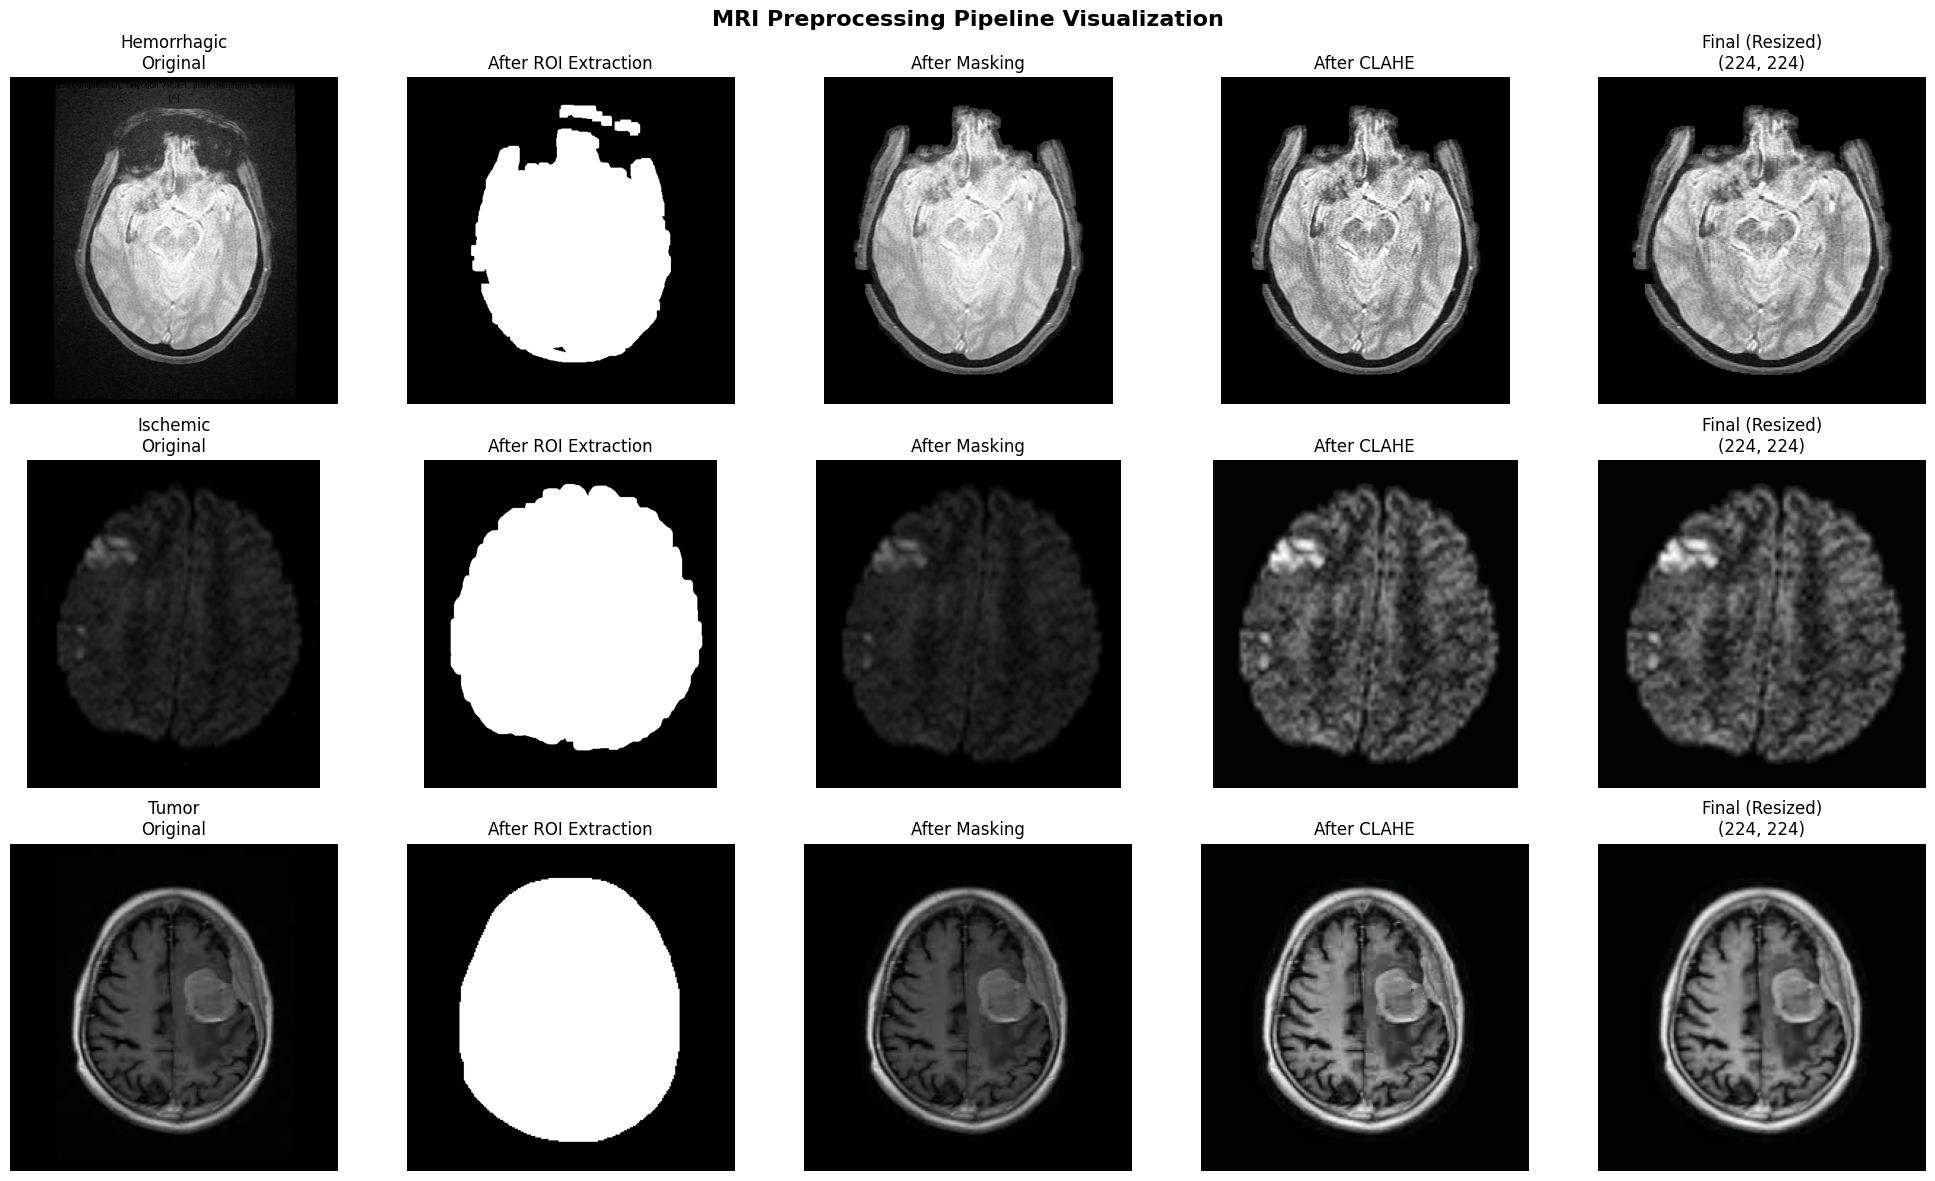

In [7]:
# --- 3. VISUALIZATION ---
def visualize_preprocessing_steps():
    """
    Visualize the preprocessing pipeline step-by-step for each class
    """
    fig, axes = plt.subplots(len(CLASSES), 5, figsize=(20, 12))
    fig.suptitle('MRI Preprocessing Pipeline Visualization', fontsize=16, fontweight='bold')
    
    # Column titles
    steps = ['Original', 'After ROI Extraction', 'After Masking', 'After CLAHE', 'Final (Resized)']
    
    for idx, cls in enumerate(CLASSES):
        src_path = os.path.join(ORIGINAL_DATA_DIR, cls)
        
        if not os.path.exists(src_path):
            print(f"⚠️ Warning: Source folder {src_path} not found.")
            continue
            
        # Get a random sample image
        files = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not files:
            continue
            
        sample_file = np.random.choice(files)
        img_path = os.path.join(src_path, sample_file)
        original_img = cv2.imread(img_path)
        
        if original_img is None:
            continue
        
        # Process step by step
        try:
            # Step 1: Original
            axes[idx, 0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
            axes[idx, 0].set_title(f'{cls}\n{steps[0]}')
            axes[idx, 0].axis('off')
            
            # Step 2: ROI Extraction (show the dilated mask for visualization)
            gray = cv2.cvtColor(original_img.copy(), cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (7, 7), 0)
            _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            kernel = np.ones((5,5), np.uint8)
            dilated = cv2.dilate(thresh, kernel, iterations=3)
            axes[idx, 1].imshow(dilated, cmap='gray')
            axes[idx, 1].set_title(steps[1])
            axes[idx, 1].axis('off')
            
            # Step 3: Masked Image
            roi = extract_roi_and_mask(original_img)
            axes[idx, 2].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            axes[idx, 2].set_title(steps[2])
            axes[idx, 2].axis('off')
            
            # Step 4: After CLAHE
            enhanced = normalize_and_clahe(roi)
            axes[idx, 3].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
            axes[idx, 3].set_title(steps[3])
            axes[idx, 3].axis('off')
            
            # Step 5: Final resized
            final = cv2.resize(enhanced, TARGET_SIZE)
            axes[idx, 4].imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
            axes[idx, 4].set_title(f'{steps[4]}\n{TARGET_SIZE}')
            axes[idx, 4].axis('off')
            
        except Exception as e:
            print(f"Error visualizing {cls}: {e}")
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_preprocessing_steps()

/tmp/ipykernel_3753722/1025457769.py:36: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[idx, 1].hist(cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY).ravel(), 256, [0,256], color='blue', alpha=0.7)
/tmp/ipykernel_3753722/1025457769.py:48: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  axes[idx, 3].hist(cv2.cvtColor(img_proc, cv2.COLOR_BGR2GRAY).ravel(), 256, [0,256], color='green', alpha=0.7)


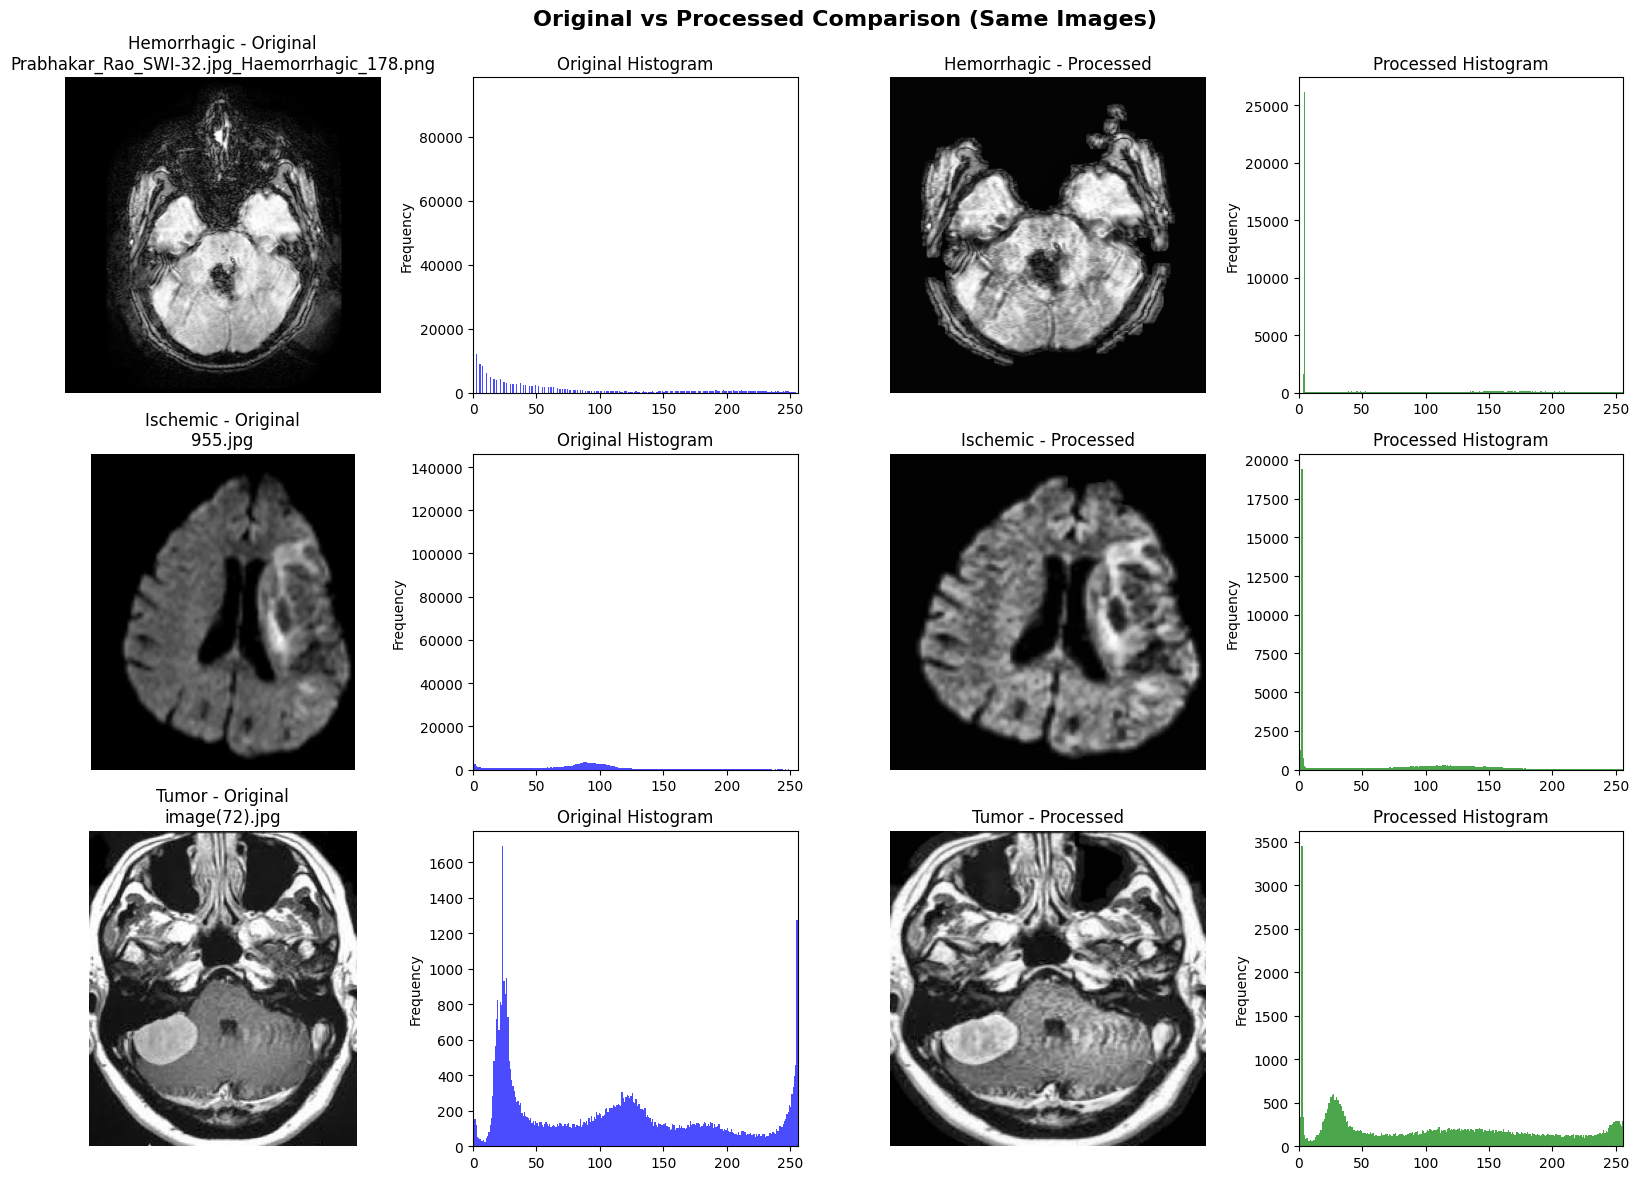

In [8]:
# --- 4. COMPARE BEFORE AND AFTER ---
def compare_original_vs_processed():
    """
    Compare the SAME image before and after processing
    """
    fig, axes = plt.subplots(len(CLASSES), 4, figsize=(16, 12))
    fig.suptitle('Original vs Processed Comparison (Same Images)', fontsize=16, fontweight='bold')
    
    for idx, cls in enumerate(CLASSES):
        src_path = os.path.join(ORIGINAL_DATA_DIR, cls)
        dst_path = os.path.join(PROCESSED_DATA_DIR, cls)
        
        if not os.path.exists(src_path) or not os.path.exists(dst_path):
            print(f"⚠️ Warning: Path not found for {cls}")
            continue
            
        # Get a random image from original
        src_files = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        if not src_files:
            continue
            
        sample_name = np.random.choice(src_files)
        
        # Check if same file exists in processed folder
        processed_path = os.path.join(dst_path, sample_name)
        original_path = os.path.join(src_path, sample_name)
        
        if os.path.exists(original_path) and os.path.exists(processed_path):
            # Original Image
            img_orig = cv2.imread(original_path)
            axes[idx, 0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
            axes[idx, 0].set_title(f'{cls} - Original\n{sample_name}')
            axes[idx, 0].axis('off')
            
            # Original Histogram
            axes[idx, 1].hist(cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY).ravel(), 256, [0,256], color='blue', alpha=0.7)
            axes[idx, 1].set_title('Original Histogram')
            axes[idx, 1].set_xlim([0, 256])
            axes[idx, 1].set_ylabel('Frequency')
            
            # Processed Image
            img_proc = cv2.imread(processed_path)
            axes[idx, 2].imshow(cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB))
            axes[idx, 2].set_title(f'{cls} - Processed')
            axes[idx, 2].axis('off')
            
            # Processed Histogram
            axes[idx, 3].hist(cv2.cvtColor(img_proc, cv2.COLOR_BGR2GRAY).ravel(), 256, [0,256], color='green', alpha=0.7)
            axes[idx, 3].set_title('Processed Histogram')
            axes[idx, 3].set_xlim([0, 256])
            axes[idx, 3].set_ylabel('Frequency')
        else:
            print(f"⚠️ Matching processed image not found for {sample_name}")
    
    plt.tight_layout()
    plt.show()

# Run comparison (only after processing is complete)
compare_original_vs_processed()